# Persistent single-linkage (HDBSCAN) clustering on sparse matrices

This is our attempt at running an HDBSCAN approach (persistent single linkage) on a sparse distance matrix. We need to figure out how to include densities (and what densities to use), and how to feed it to HDBSCAN directly.

The sparse distance matrices are obtained via transformation of the original UMAP weights OR original KNN-weights OR from some edge pruning strategies.

In [1]:
!git branch

* main


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from collections import Counter
from scipy.stats import mode

sns.set()

In [4]:
import hdbscan
import scipy.sparse
import sklearn.cluster
from hdbscan._hdbscan_tree import (
    condense_tree,
    compute_stability,
    get_clusters,
    outlier_scores,
)
from hdbscan.plots import CondensedTree, SingleLinkageTree, MinimumSpanningTree

## Get clusters from a (disconnected) sparse distance matrix

* The 0-values indicate "far away" points

If the matrix has disconnected components (when viewed as a graph), HDBSCAN does not work. To get around this, we have tried clustering each component separately or just adding edges to glue the different parts together.

In [5]:
def clustering_from_sparse(D,
                       connected_component_method = 'glue', # 'glue' or 'individual'
                       cluster_selection_method = 'eom',
                       allow_single_cluster=False,
                       cluster_selection_epsilon=0.0,
                       max_cluster_size=0,
                       min_cluster_size=10,
                       no_split_size = 100,
                       alpha = 1.2):
    par = locals()

    cc = scipy.sparse.csgraph.connected_components(D)
    n = D.shape[0]

    if(cc[0] == 1):
        labels = clustering_from_sparse_connected(**par)
        
    elif (connected_component_method == 'glue'):
        print("Disconnected distance matrix: \n -Connecting distance matrix")
        labels = clustering_from_sparse_force_connection(**par)
        
    elif( connected_component_method == 'individual' ):
        print("Disconnected distance matrix: \n -Performing clustering on individual connected components")
        labels = clustering_from_sparse_on_individual_cc(**par)
        
    else:
        raise ValueError('Parameter should be glue or individual')
        
    return(labels)


# Single linkage on sparse matrix when the initial distance matrix is connected.
def clustering_from_sparse_connected(D,
                       connected_component_method = 'glue',
                       cluster_selection_method = 'eom',
                       allow_single_cluster=False,
                       cluster_selection_epsilon=0.0,
                       max_cluster_size=0,
                       min_cluster_size=10,
                       no_split_size = 100,
                       alpha = 1.2):
    
    mst = scipy.sparse.csgraph.minimum_spanning_tree(D)
    mst = mst.tocoo()
    mst_array = np.vstack([mst.row, mst.col, mst.data]).T
    
    # Sort edges of the min_spanning_tree by weight
    mst_array = mst_array[np.argsort(mst_array.T[2], kind="mergesort"), :]

    # Convert edge list into standard hierarchical clustering format
    single_linkage_tree = sklearn.cluster._hierarchical_fast._single_linkage_label(mst_array)
    
    ## HDBSCAN function
    cd_tree = condense_tree(single_linkage_tree, min_cluster_size)
    
    ## HDBSCAN function
    stability_dict = compute_stability(cd_tree)
    
    ## HDBSCAN function
    labels, probabilities, stabilities = get_clusters(
            cd_tree,
            stability_dict,
            cluster_selection_method = cluster_selection_method,
            allow_single_cluster = allow_single_cluster,
            cluster_selection_epsilon=cluster_selection_epsilon,
            max_cluster_size=max_cluster_size
        )
    return(labels)


# Performing clustering on individual connected components of the sparse distance matrix
def clustering_from_sparse_on_individual_cc(D,
                       connected_component_method = 'glue',
                       cluster_selection_method = 'eom',
                       allow_single_cluster=False,
                       cluster_selection_epsilon=0.0,
                       max_cluster_size=0,
                       min_cluster_size=10,
                       no_split_size = 100,
                       alpha = 1.2):
    
    # Check connected components
    cc = scipy.sparse.csgraph.connected_components(D)
    n = D.shape[0]
    
    if(cc[0]==1):
        labels = clustering_from_sparse_connected(D)
    else:
        labels = np.array([-1]*n)
        for comp in range(cc[0]):
            w = (cc[1]==comp)
            m = sum(w)
            if(m < min_cluster_size):
                continue
            elif(m < no_split_size):
                labels_part = np.zeros(m)
            else:
                D_part = D[w, :][:, w]
                labels_part = clustering_from_sparse_connected(D_part,
                                                            cluster_selection_method = cluster_selection_method,
                                                            allow_single_cluster = allow_single_cluster,
                                                            cluster_selection_epsilon=cluster_selection_epsilon,
                                                            max_cluster_size=max_cluster_size,
                                                            min_cluster_size=min_cluster_size)
                if(sum(labels_part==-1)>(len(labels_part)/2)):
                    labels_part = 0*labels_part
            w[w] = (labels_part>=0)
            labels[w] = (labels_part[labels_part>=0] + max(labels) + 1)
    return(labels)


# Adding large distance values (alpha * largest) to sparse distance matrix to make it connected
def clustering_from_sparse_force_connection(D,
                       connected_component_method = 'glue',
                       cluster_selection_method = 'eom',
                       allow_single_cluster=False,
                       cluster_selection_epsilon=0.0,
                       max_cluster_size=0,
                       min_cluster_size=10,
                       no_split_size = 100,
                       alpha = 1.2):
    
    # Check connected components
    cc = scipy.sparse.csgraph.connected_components(D)
    cc_list = cc[1].tolist()
    if(cc[0]>1): # Add edges to connect if more than one connected component
        m = max(D.data)
 
        rows = []
        cols = []
        vals = []
        for i in set(cc[1]):
            for j in set(cc[1]):
                if(i>j):
                    new_i = cc_list.index(i)
                    new_j = cc_list.index(j)
                    rows.extend([new_i, new_j])
                    cols.extend([new_j, new_i])
                    vals.extend([alpha*m, alpha*m])
        D_glue = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=D.shape)
        D_new = D + D_glue
    else:
        D_new = D
                       
    labels = clustering_from_sparse_connected(D_new)
    return(labels)

# Matrix transformations

We are trying different edge weights before applying clustering the graph.

The 4 matrices we get from UMAP are:
* A_w is a sparse, non-symmetric matrix containing the umap weights (csr)
* A_umap is the symmetrized version of A_w (csr)
* dists is a sparse matrix containing the high dimensional distances (csr)
* knn_dists is a dense matrix of size (number of points)x(k) containing the distance to the kNN in ascending order


In [6]:
# Inverse values (this is an attempt for going from similarities to dissimilarities)
def get_inverse_sim(A):

    D = A.copy()
    m = min(A.data)
    if(m<0.001):
        m = 0.001
    else:
        m = 0
    v = np.array([1/(x+m) for x in A.data])
    D.data = v
        
    return(D)

# This is another attempt for going from similarities to dissimilarities
def get_negative_sim(A):

    D = A.copy()
    m = 1
    if(max(A.data)>1):
        m = max(A.data)
    v = np.array([1-(x/m) for x in A.data])
    D.data = v
        
    return(D)

# Romeo and Juliet: each edge weights is replaced by the average of weights (including 0-weight)
# between the two endpoints' neighborhoods. If a node appears in both neiborhoods, we "clone"
# it and add an edge of weight 1 between the node and itself.
def neighborhood_amplification(W, alpha = 0.5):
    A = 1*(W!=0)
    I = scipy.sparse.identity(A.shape[0])
    
    d = A.sum(axis=0).tolist()[0]
    D_inv = scipy.sparse.diags([1/x for x in d])
    
    # + I is to include self-loops with edge weights of 1.
    
    # A : unweighted adjacency
    # W : weighted adjacency
    # D_inv : diagonal matrix of 1/d_i
    M = D_inv*((A.T*(W+I)*A).multiply(A))*D_inv
    P = (W+M) - W.multiply(M)
    
    #  mix_ratio(x+y-x*y) + (1-mix_ratio)(x*y)
    R = ((1-alpha)*W+alpha*M)
    
    # R = alpha*(M+W-P) + (1-alpha)*(P)
    return(R)

# Count number of 1, 3 and 4 cycles and edge is involved in
def get_egonet_distance(A_umap, plot_distribution=False):
    # Make the matrix binary
    A = 0.5*(A_umap!=0)
    
    counts = A.multiply(A + A*A + A*A*A)
    
    D = counts.copy()
    D.data = np.array([1/x for x in D.data])
        
    return(D)

def get_triangle_distance(A_w):
    # Make the matrix binary
    A = 1*(A_w!=0)
    # Count number of triangles in which each pair of node is involved
    counts = A.multiply(A*A)
    
    C = dict()
    N = max(counts.data)
    for n in range(1,N+1):
        C[n] = (counts==n)*1/n
    D = C[2]
    for n in range(3,N+1):
        D += C[n]
        
    return(D)

# Replace high dimensional points by the centroid of their neighbors
def get_avg_neighbor_distance(raw_data, k=8):
    A_w, knn_indices, knn_dists = knn_matrix(X=raw_data, k=k, return_all=True)
    w_d = np.mean(A_w.sum(axis=1))
    family_data = (1/w_d)*(A_w.T)*raw_data
    
    # if(k is None):
    #     k = get_dataset_params(dataset_id)['n_neighbors']

    A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=family_data, 
                                                     n_neighbors=k, 
                                                     random_state=0, 
                                                     metric='euclidean', 
                                                     return_dists=True,
                                                    set_op_mix_ratio=0.5)

    D = get_inverse_sim(A_umap)
    return(D)

# Clustering algorithm
These are the steps we use to feed a sparse distance matrix to the single linkage...
We are not using HDBSCAN at the moment, but this is where we would like to go.

## Run for all other data sets

In [7]:
def get_single_linkage_clustering(dataset_id, distance_function, k=None):
    raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)
    display(Markdown(f'### {dataset_name}'))
    
    if(distance_function.__name__ == "get_avg_neighbor_distance"):
        D = distance_function(raw_data)
    else:
        if(k is None):
            k = get_dataset_params(dataset_id)['n_neighbors']

        A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                                         n_neighbors=k, 
                                                         random_state=0, 
                                                         metric='euclidean', 
                                                         return_dists=True,
                                                         set_op_mix_ratio=0.5)
        D = distance_function(A_umap)

    labels = clustering_from_sparse(D)

    ari = adjusted_rand_score(targets, labels)
    ami = adjusted_mutual_info_score(targets, labels)
    print(f'ARI = {ari} and AMI = {ami}')
    return(labels, ari, ami, targets)

In [8]:
experimentList = [
  {'description' : 'UMAP weights (inv)', 'function': get_inverse_sim},
  # {'description' : 'UMAP weights (neg)', 'function': get_negative_sim},
  {'description' : 'Number of supporting triangles', 'function': get_triangle_distance},
  {'description' : "Average of UMAP weight and mean families' weights", 'function': neighborhood_amplification},
  {'description' : 'Number of 1,3,4-cycles containg the two endpoints', 'function': get_egonet_distance},
  {'description' : "UMAP of modified data points: neighbors' average", 'function': get_avg_neighbor_distance}
]

### Refinement/coarsening measure

Here, we define a measure to measure how much a partition is the refinement of another partition. To decide if partition_1 is a refinement of partition_2, we map all parts of partition_1 to to the part of partition_2 with the largest overlap. We then add the number of elements not in the overlap. A high value means that it is not a refinement.

In [9]:
def measure_refinement(targets, labels):
    ind_max = max(labels)+1
    ind_min = min(labels)
    not_in_dominant = 0
    for grp in range(ind_min,ind_max):
        subtargets = targets[labels==grp]
        sizeLarge = mode(subtargets)[1][0]
        not_in_dominant = not_in_dominant + (len(subtargets)-sizeLarge)
    return(1 - not_in_dominant/len(targets))

In [ ]:
results_ari_ami = []

for j, exp in enumerate(experimentList):
    
    description = exp['description']
    function = exp['function']
    display(Markdown(f'# {description}'))
    
    for i in range(5):
        labels, ari, ami, targets = get_single_linkage_clustering(dataset_id=i, 
                                      distance_function = function, k=10)
        results_ari_ami.append([f'Experiment {j}' , 
                                get_dataset_name(i), 
                                description, 
                                ari, 
                                ami, 
                                sum(labels==-1)/len(labels),
                                max(targets)+1,
                                max(labels)+1,
                                mode(targets)[1][0],
                                mode(labels)[1][0],
                                measure_refinement(targets, labels),
                                measure_refinement(labels, targets)
                                ])
        
results_df_10 = pd.DataFrame(results_ari_ami, 
                          columns=['Experiment', 'Dataset', 'Description', 'ARI', 'AMI', 'Percent noise', 
                                   'Nb clusters (true)', 'Nb clusters (predicted)', 'Largest cluster (true)', 'Largest cluster(predicted)', 
                                   'Refinement', 'Coarsening'])

In [77]:
results_df_10.sort_values(['Experiment', 'Dataset'])

,Experiment,Dataset,Description,ARI,AMI,Percent noise,Nb clusters (true),Nb clusters (predicted),Largest cluster (true),Largest cluster(predicted),Refinement,Coarsening
4,Experiment 0,buildings,UMAP weights (inv),0.227608,0.664096,0.093825,41,166,334,392,0.834610,0.303494
1,Experiment 0,coil,UMAP weights (inv),0.947356,0.972019,0.003472,21,26,72,72,1.000000,0.922917
2,Experiment 0,mnist,UMAP weights (inv),-0.000003,0.000829,0.006029,10,2,4002,34779,0.114686,0.993686
0,Experiment 0,pendigits,UMAP weights (inv),0.084600,0.402341,0.010017,10,11,183,1402,0.321647,0.899277
3,Experiment 0,usps,UMAP weights (inv),0.050193,0.432855,0.340934,11,258,1553,3170,0.702086,0.384169
9,Experiment 1,buildings,Number of supporting triangles,0.108242,0.587149,0.236955,41,130,334,990,0.677836,0.365007
6,Experiment 1,coil,Number of supporting triangles,0.683375,0.855778,0.085417,21,25,72,174,0.855556,0.775694
7,Experiment 1,mnist,Number of supporting triangles,0.000024,0.000388,0.000400,10,2,4002,34916,0.115000,0.997600
5,Experiment 1,pendigits,Number of supporting triangles,0.659456,0.781665,0.101280,10,23,183,280,0.844185,0.741792
8,Experiment 1,usps,Number of supporting triangles,0.051956,0.194839,0.119811,11,5,1553,7358,0.258980,0.873951


In [78]:
results_df = results_df_10

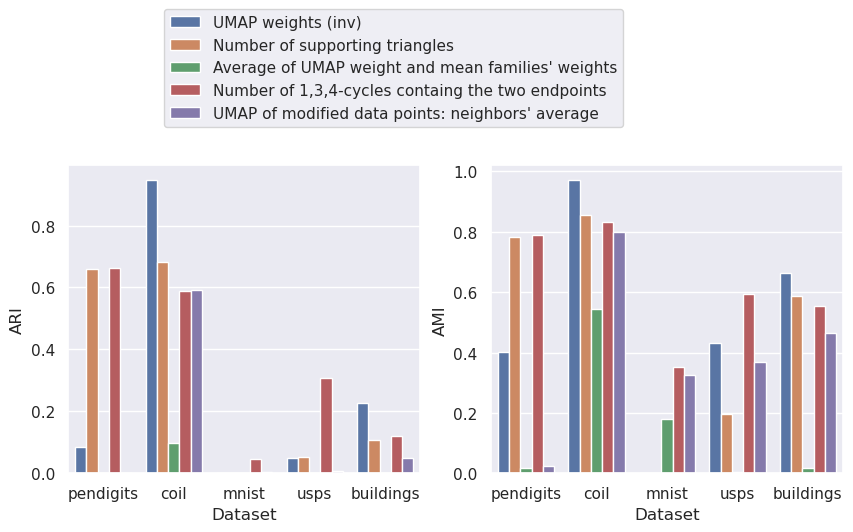

In [81]:
# fig = plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=results_df, x='Dataset', y='ARI', 
            hue='Description', ax=ax1)
sns.barplot(data=results_df, x='Dataset', y='AMI', 
            hue='Description', ax=ax2)
lgd = ax1.legend(loc='lower left', bbox_to_anchor=(0.25,1.1))
ax2.legend_.remove()
# sns.barplot(data=results_df, x='Dataset', y='AMI', hue='Description', ax=ax2)
# # lgd = sns.move_legend(ax, "upper center", bbox_to_anchor=(1, 1))
plt.savefig('ExperimentSummary_ari_ami.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

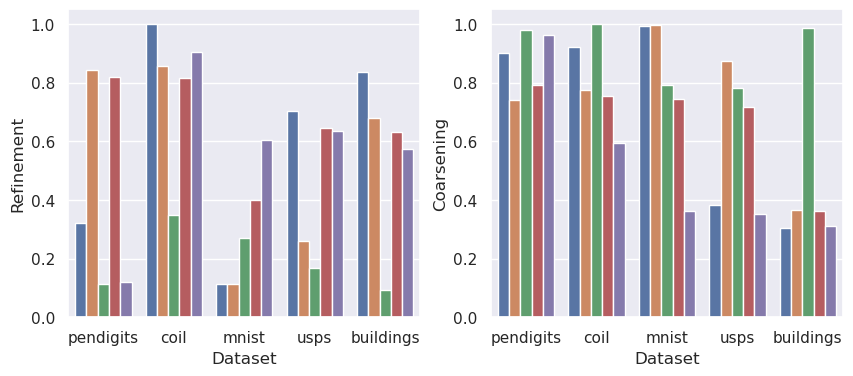

In [83]:
# fig = plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=results_df, x='Dataset', y='Refinement', 
            hue='Description', ax=ax1)
sns.barplot(data=results_df, x='Dataset', y='Coarsening', 
            hue='Description', ax=ax2)
# lgd = ax1.legend(loc='lower left', bbox_to_anchor=(0.25,1.1))
ax2.legend_.remove()
ax1.legend_.remove()
# sns.barplot(data=results_df, x='Dataset', y='AMI', hue='Description', ax=ax2)
# # lgd = sns.move_legend(ax, "upper center", bbox_to_anchor=(1, 1))
plt.savefig('ExperimentSummary_refine_coarse.png', bbox_inches='tight')

### Problem with get_negative_sim transformation

Not sure why, but the following line does not work when D is obtained from : D =  get_negative_sim(A_umap)

single_linkage_tree = sklearn.cluster._hierarchical_fast._single_linkage_label(mst_array)

In [25]:
dataset_id=0
raw_data, targets, dataset_name = get_dataset(dataset_id)
display(Markdown(f'### {dataset_name}'))

k = get_dataset_params(dataset_id)['n_neighbors']

A_umap, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(X=raw_data, 
                                         not_in_dominant  n_neighbors=k, 
                                                 random_state=0, 
                                                 metric='euclidean', 
                                                 return_dists=True,
                                                 set_op_mix_ratio=0.5)
D =  get_inverse_sim(A_umap)

labels = clustering_from_sparse(D)

ari = adjusted_rand_score(targets, labels)
ami = adjusted_mutual_info_score(targets, labels)
print(f'ARI = {ari} and AMI = {ami}')

### pendigits

ARI = 0.10861192021501603 and AMI = 0.4367895445871948


## Summarize what I have done

Ran persistant clustering games on different "dissimilarity matrices". The matrices I have looked at are the following (when a similarity matrix is given, for instance UMAP, we have transformed it, using its elementwise inverse).

The different weights tried for each edge are:

* UMAP weight - no neighborhood information added
* Number of supporting triangles (or size of intersection of the two neighborhoods)
* Average of edge (and non-edge) weights between the two neighborhoods added to the original UMAP weight - this is what is discussed in the original post here.
* Number of cycles of length 1, 3 and 4 (cycles of length 1 are just edges, this is to avoid disconnecting the graph)
* UMAP weight of modified high dimensional representations. Each point is represented as its neighbors' average point.

I also want to include the Weisserstein distance between the high dimensional neighborhoods, if someone can point me to code I could use that would be helpful?